In [1]:
#!pip install optuna transformers scikit-learn gradio pandas

RoBERTa:

> Why: RoBERTa has shown excellent performance across various NLP tasks, often outperforming BERT due to its robust optimization techniques and larger training corpus. It handles nuances in text very well, which is crucial for sentiment analysis.
    Strengths: Strong performance on a wide range of tasks, robust pre-training.

DistilBERT:

> Why: DistilBERT is a distilled version of BERT that retains much of BERT's performance while being faster and more resource-efficient. It provides a good trade-off between performance and computational efficiency.
    Strengths: Faster and lighter than BERT, making it suitable for applications where speed and resource usage are considerations.

Electra:

> Why: Electra uses a different pre-training approach where the model learns to distinguish real input tokens from fake ones generated by another model. This approach is computationally efficient and leads to strong performance.
    Strengths: Computationally efficient, strong performance, particularly effective on downstream tasks after pre-training.

Train and Evaluate All Models:

> Train each model with default hyperparameters and evaluate their performance on the validation set.

Select the Best Model:

> Select the model with the highest F1 score on the validation set.

Fine-Tune the Best Model Using Optuna:

> Use Optuna to optimize the hyperparameters for the best-performing model.

Store All Models and Tokenizers:

> Store the trained models and their tokenizers in the models dictionary for use during prediction.

Predict Function:

> The predict function takes a model, tokenizer, and text input, and returns the predicted label.

Predict Sample Function:

> The predict_sample function takes a sample index, retrieves the sample text, and gets predictions from all models, including the fine-tuned model.
    The function returns the text, ground truth label, and predictions from each model.

Gradio Interface:

> Use the Gradio interface to select a sample and display predictions from all models, including the fine-tuned model.

INFO:Sentiment-Analysis:Using device: NVIDIA GeForce RTX 4080
INFO:Sentiment-Analysis:Training model: RoBERTa
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:Sentiment-Analysis:Unique labels: {0, 1, 2, 3, 4}
INFO:Sentiment-Analysis:Unique labels: {0, 1, 2, 3, 4}
C:\Users\david\anaconda3\envs\SentimentAnalysis\lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.032900,1.158272,0.489500,0.570156,0.489500,0.481982
2,0.905000,0.968321,0.598500,0.592762,0.598500,0.593472
3,0.571200,1.006930,0.603500,0.608081,0.603500,0.604309


INFO:Sentiment-Analysis:Evaluation results for RoBERTa: {'eval_accuracy': 0.6035, 'eval_precision': 0.6080813252760849, 'eval_recall': 0.6035, 'eval_f1': 0.6043085689159408, 'eval_loss': 1.0069303512573242, 'eval_runtime': 13.047, 'eval_samples_per_second': 153.292, 'eval_steps_per_second': 9.581, 'epoch': 3.0, 'predictions': [[2.7042360305786133, 2.589825391769409, -0.2264103889465332, -1.944216251373291, -2.6912789344787598], [-2.0283045768737793, -2.5463945865631104, -1.4887195825576782, 2.0866217613220215, 4.383316516876221], [-3.0932796001434326, -0.2939361333847046, 2.6302342414855957, 1.9111233949661255, -1.5365382432937622], [-3.6869401931762695, -2.20184326171875, 1.4812290668487549, 3.1995184421539307, 0.8062401413917542], [-2.990535259246826, -1.6804174184799194, 1.0274940729141235, 2.6778554916381836, 0.8203476667404175], [-3.2039992809295654, -2.634315252304077, 0.4120189845561981, 3.0884978771209717, 2.025023937225342], [-2.436751127243042, -2.837545156478882, -1.08977735

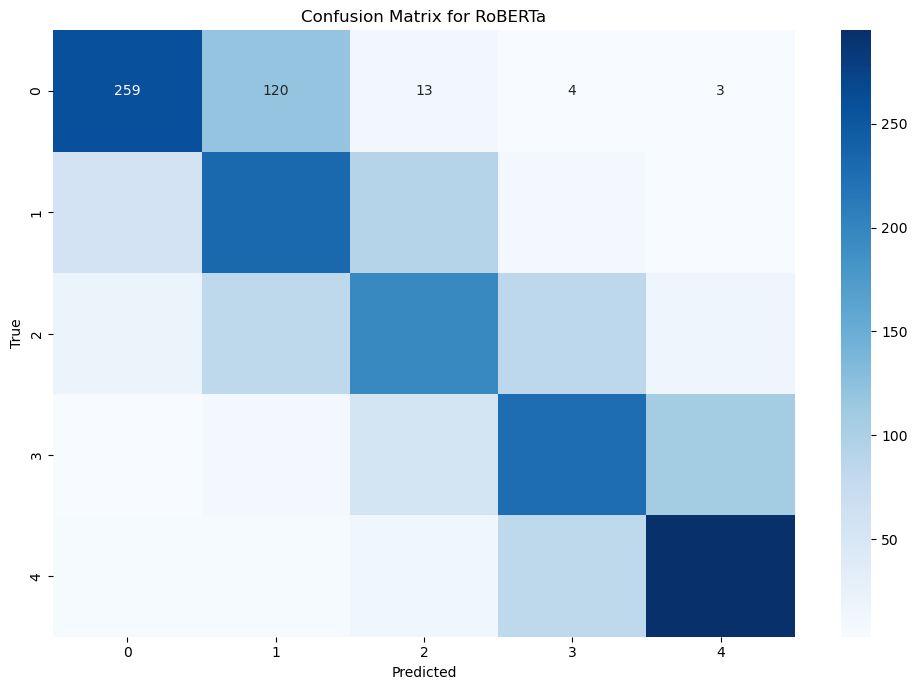

INFO:Sentiment-Analysis:Training model: DistilBERT
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:Sentiment-Analysis:Unique labels: {0, 1, 2, 3, 4}
INFO:Sentiment-Analysis:Unique labels: {0, 1, 2, 3, 4}
C:\Users\david\anaconda3\envs\SentimentAnalysis\lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.176600,1.187272,0.486500,0.496837,0.486500,0.487689
2,0.932400,1.083139,0.557000,0.554315,0.557000,0.554260
3,0.641000,1.136189,0.549000,0.552679,0.549000,0.548831


INFO:Sentiment-Analysis:Evaluation results for DistilBERT: {'eval_accuracy': 0.549, 'eval_precision': 0.5526790143149269, 'eval_recall': 0.549, 'eval_f1': 0.5488308557910826, 'eval_loss': 1.1361894607543945, 'eval_runtime': 6.855, 'eval_samples_per_second': 291.758, 'eval_steps_per_second': 18.235, 'epoch': 3.0, 'predictions': [[-1.7946513891220093, -0.17670486867427826, 1.2246415615081787, 1.0081251859664917, -0.33101460337638855], [-2.2862389087677, -2.295365333557129, -1.1299045085906982, 1.7062122821807861, 3.86808180809021], [-1.833137035369873, 0.4585828185081482, 1.7251935005187988, 0.7944315671920776, -1.3486496210098267], [-2.9441301822662354, -1.5211892127990723, 1.480842113494873, 2.417604446411133, 0.24151667952537537], [-0.6004114747047424, 1.0801912546157837, 0.8555480241775513, -0.34131255745887756, -1.5431650876998901], [-2.8760690689086914, -1.9806753396987915, 0.9041298031806946, 2.5179009437561035, 0.8930519223213196], [-2.6176912784576416, -2.569612979888916, -0.854

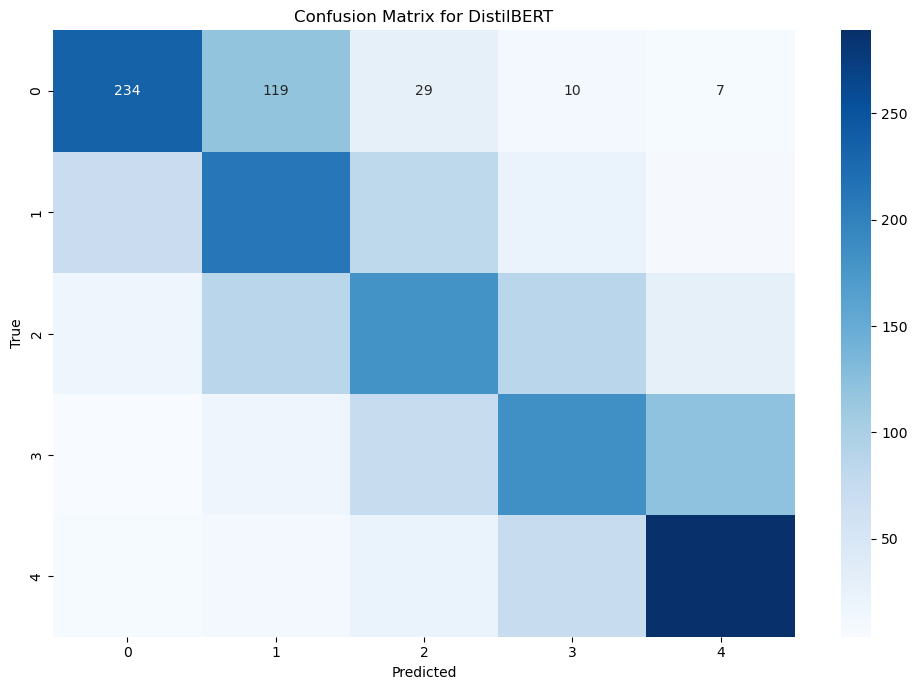

INFO:Sentiment-Analysis:Training model: Electra
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:Sentiment-Analysis:Unique labels: {0, 1, 2, 3, 4}
INFO:Sentiment-Analysis:Unique labels: {0, 1, 2, 3, 4}
C:\Users\david\anaconda3\envs\SentimentAnalysis\lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.221100,1.155396,0.502500,0.534430,0.502500,0.507588
2,1.042000,1.029508,0.578500,0.575756,0.578500,0.575484
3,0.582900,1.040616,0.588500,0.592250,0.588500,0.589061


INFO:Sentiment-Analysis:Evaluation results for Electra: {'eval_accuracy': 0.5885, 'eval_precision': 0.5922502014944564, 'eval_recall': 0.5885, 'eval_f1': 0.5890609900340433, 'eval_loss': 1.0406162738800049, 'eval_runtime': 12.9492, 'eval_samples_per_second': 154.45, 'eval_steps_per_second': 9.653, 'epoch': 3.0, 'predictions': [[1.9513932466506958, 2.5565989017486572, -0.13835977017879486, -1.8742974996566772, -2.704481363296509], [-1.892927885055542, -2.2211663722991943, -1.111048698425293, 1.5503968000411987, 4.06730318069458], [-2.381453275680542, -0.8890600204467773, 1.7594410181045532, 1.8010998964309692, -0.4210382401943207], [-2.7286102771759033, -1.4003483057022095, 1.6313825845718384, 2.32417893409729, 0.052536699920892715], [-2.619938373565674, -1.3668211698532104, 1.2264604568481445, 2.2188668251037598, 0.22643646597862244], [-2.884307861328125, -2.183556318283081, 0.44744497537612915, 2.8121566772460938, 1.7156212329864502], [-2.598621129989624, -2.4463043212890625, -0.69225

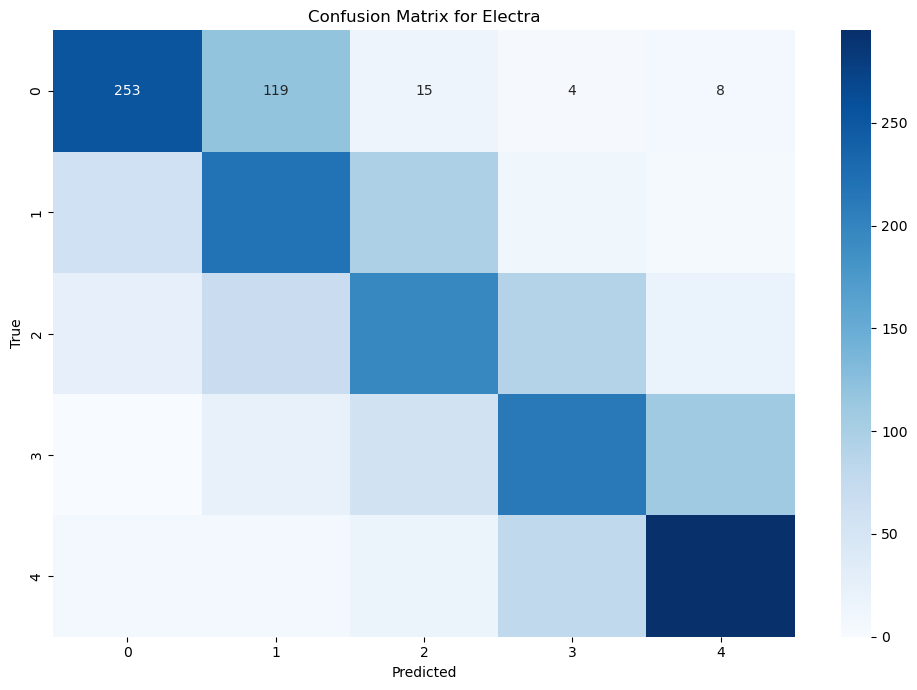

INFO:Sentiment-Analysis:Best model: RoBERTa with F1 score: 0.6043085689159408
[I 2024-06-10 17:43:45,032] A new study created in memory with name: no-name-fe08aece-1dac-418f-8797-782593d14823
INFO:Sentiment-Analysis:Training model: RoBERTa
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:Sentiment-Analysis:Unique labels: {0, 1, 2, 3, 4}
INFO:Sentiment-Analysis:Unique labels: {0, 1, 2, 3, 4}
C:\Users\david\anaconda3\envs\SentimentAnalysis\lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.089900,1.002217,0.574000,0.569050,0.574000,0.568890
2,0.948700,0.963920,0.604000,0.608642,0.604000,0.605022
3,0.703000,0.957789,0.608000,0.610386,0.608000,0.607957


INFO:Sentiment-Analysis:Evaluation results for RoBERTa: {'eval_accuracy': 0.608, 'eval_precision': 0.610386165496291, 'eval_recall': 0.608, 'eval_f1': 0.6079566583197441, 'eval_loss': 0.9577891826629639, 'eval_runtime': 113.1353, 'eval_samples_per_second': 17.678, 'eval_steps_per_second': 0.849, 'epoch': 3.0, 'predictions': [[1.9990508556365967, 2.2042977809906006, -0.3377658724784851, -1.5907796621322632, -2.4156956672668457], [-1.9884601831436157, -2.1621780395507812, -1.3443177938461304, 1.5205187797546387, 4.266417026519775], [-2.487034797668457, 0.10470402985811234, 2.5014076232910156, 1.3032567501068115, -1.610557198524475], [-3.1511006355285645, -1.7086503505706787, 1.3146275281906128, 2.7490737438201904, 0.6962406635284424], [-2.9605791568756104, -2.0182015895843506, 0.2818174660205841, 2.707803726196289, 1.8856863975524902], [-2.875480890274048, -2.15988826751709, 0.34278735518455505, 2.7991909980773926, 2.062422275543213], [-2.6271259784698486, -2.4790492057800293, -0.7231427

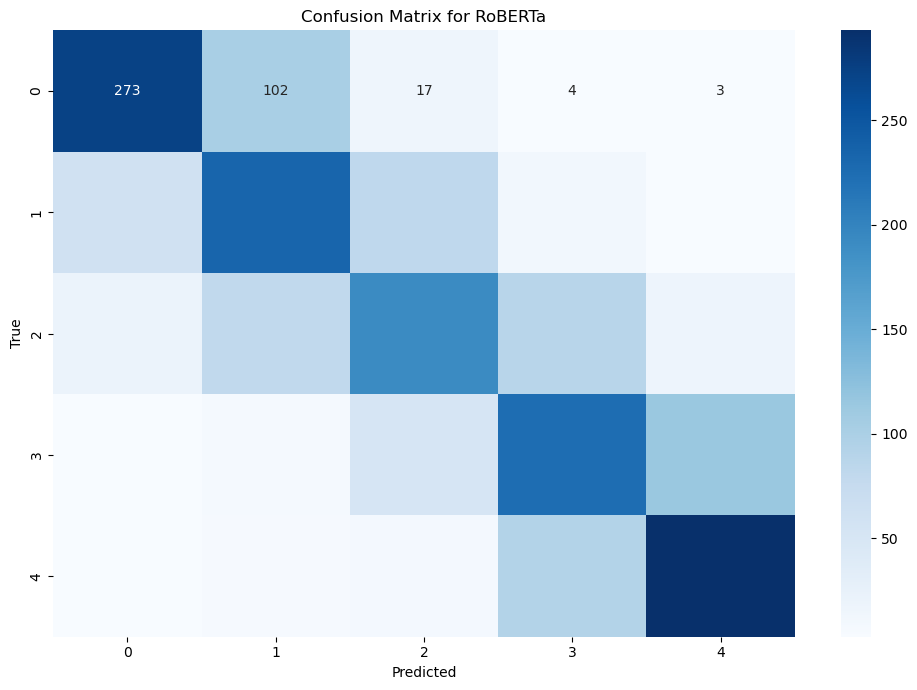

[I 2024-06-10 18:27:30,324] Trial 0 finished with value: 0.6079566583197441 and parameters: {'learning_rate': 2.655349455017661e-05, 'batch_size': 21}. Best is trial 0 with value: 0.6079566583197441.
INFO:Sentiment-Analysis:Training model: RoBERTa
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:Sentiment-Analysis:Unique labels: {0, 1, 2, 3, 4}
INFO:Sentiment-Analysis:Unique labels: {0, 1, 2, 3, 4}
C:\Users\david\anaconda3\envs\SentimentAnalysis\lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.031300,1.001681,0.577500,0.570982,0.577500,0.570731
2,0.984800,0.954664,0.596000,0.595832,0.596000,0.593809
3,0.586600,0.959564,0.613500,0.615357,0.613500,0.613622


INFO:Sentiment-Analysis:Evaluation results for RoBERTa: {'eval_accuracy': 0.6135, 'eval_precision': 0.6153566206358246, 'eval_recall': 0.6135, 'eval_f1': 0.6136221439596038, 'eval_loss': 0.9595642685890198, 'eval_runtime': 12.8721, 'eval_samples_per_second': 155.374, 'eval_steps_per_second': 9.167, 'epoch': 3.0, 'predictions': [[1.5978364944458008, 2.471431255340576, 0.3220658302307129, -1.4794518947601318, -2.611776113510132], [-2.149355888366699, -2.2492830753326416, -1.2995843887329102, 1.5226521492004395, 4.266916275024414], [-2.1984057426452637, 0.8147368431091309, 2.698333740234375, 0.7627508640289307, -2.1948177814483643], [-3.0644376277923584, -1.724510669708252, 1.331689476966858, 2.682884454727173, 0.629821240901947], [-2.4974563121795654, -1.6817644834518433, 0.4847869873046875, 2.3197975158691406, 1.290094256401062], [-2.6648190021514893, -2.2695744037628174, 0.3484027087688446, 2.67490553855896, 1.8835320472717285], [-2.576948642730713, -2.57910418510437, -0.77257865667343

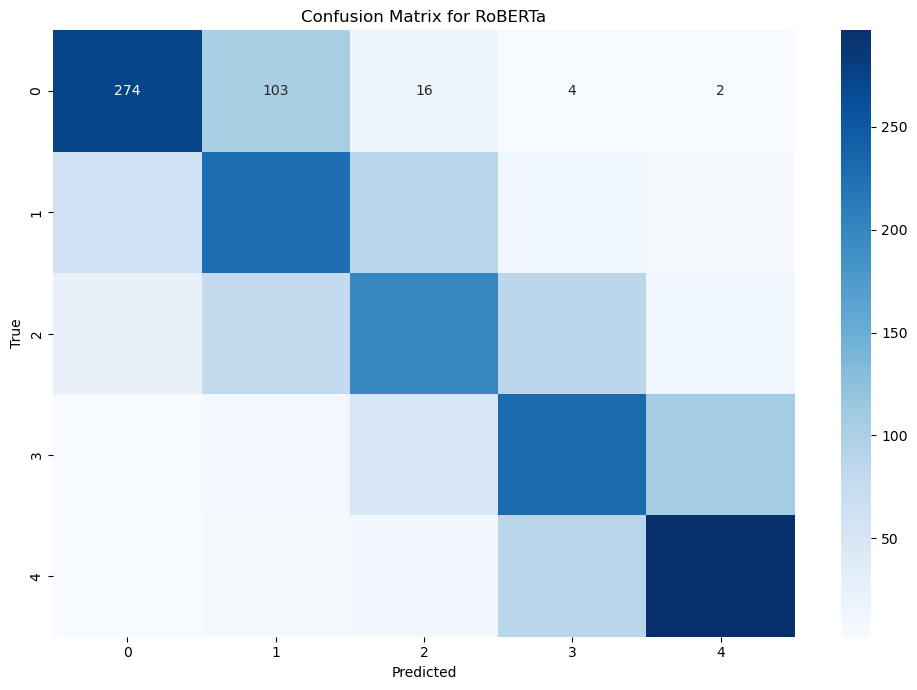

[I 2024-06-10 18:36:19,355] Trial 1 finished with value: 0.6136221439596038 and parameters: {'learning_rate': 1.9571129476432532e-05, 'batch_size': 17}. Best is trial 1 with value: 0.6136221439596038.
INFO:Sentiment-Analysis:Training model: RoBERTa
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:Sentiment-Analysis:Unique labels: {0, 1, 2, 3, 4}
INFO:Sentiment-Analysis:Unique labels: {0, 1, 2, 3, 4}
C:\Users\david\anaconda3\envs\SentimentAnalysis\lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.082200,1.055580,0.541000,0.562348,0.541000,0.542962
2,0.943200,0.970167,0.584500,0.582728,0.584500,0.582220
3,0.625200,0.985528,0.604000,0.605703,0.604000,0.603814


INFO:Sentiment-Analysis:Evaluation results for RoBERTa: {'eval_accuracy': 0.604, 'eval_precision': 0.6057027527896331, 'eval_recall': 0.604, 'eval_f1': 0.6038136030224643, 'eval_loss': 0.9855284690856934, 'eval_runtime': 12.7249, 'eval_samples_per_second': 157.172, 'eval_steps_per_second': 8.33, 'epoch': 3.0, 'predictions': [[2.8844568729400635, 2.208237409591675, -0.6038147211074829, -1.8528673648834229, -2.6018388271331787], [-1.9918298721313477, -2.6017420291900635, -1.3559961318969727, 1.8047256469726562, 4.509989261627197], [-2.2966084480285645, 0.9856610894203186, 2.839259624481201, 0.5277285575866699, -2.603517770767212], [-3.5837204456329346, -2.071969985961914, 0.954465389251709, 3.1169259548187256, 1.2673001289367676], [-3.0175604820251465, -1.105220079421997, 1.3994027376174927, 2.303560972213745, 0.07868911325931549], [-3.346341848373413, -2.161240577697754, 0.5565418004989624, 2.923959732055664, 1.9089494943618774], [-2.839895009994507, -2.763575792312622, -0.6008707880973

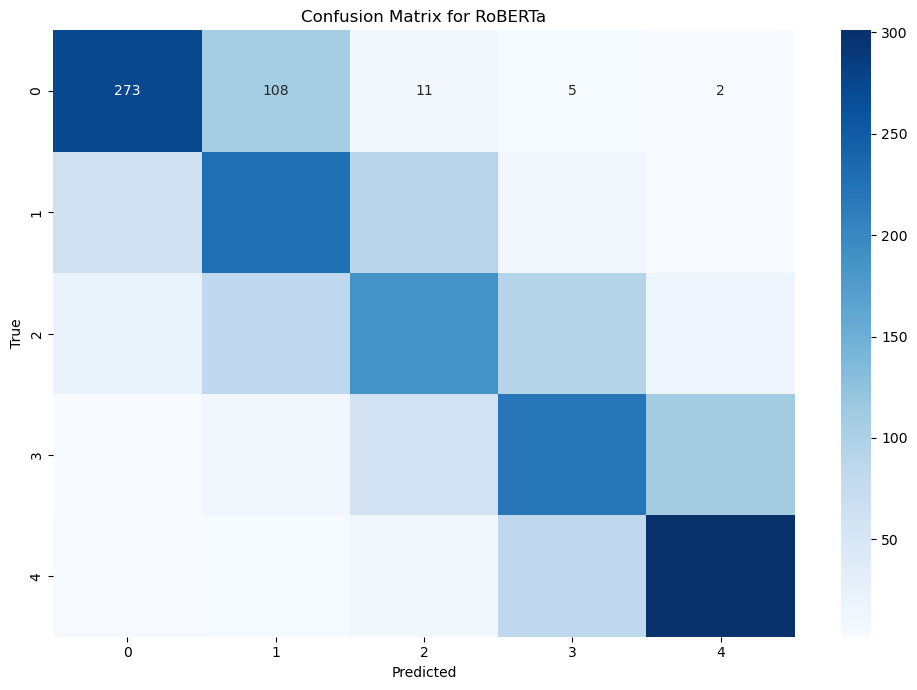

[I 2024-06-10 18:48:07,389] Trial 2 finished with value: 0.6038136030224643 and parameters: {'learning_rate': 4.8499719271740005e-05, 'batch_size': 19}. Best is trial 1 with value: 0.6136221439596038.
INFO:Sentiment-Analysis:Training model: RoBERTa
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:Sentiment-Analysis:Unique labels: {0, 1, 2, 3, 4}
INFO:Sentiment-Analysis:Unique labels: {0, 1, 2, 3, 4}
C:\Users\david\anaconda3\envs\SentimentAnalysis\lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.102000,1.015448,0.559500,0.559794,0.559500,0.549536
2,1.033700,0.990157,0.578000,0.587770,0.578000,0.574502
3,0.782100,0.970344,0.619500,0.621098,0.619500,0.619498


INFO:Sentiment-Analysis:Evaluation results for RoBERTa: {'eval_accuracy': 0.6195, 'eval_precision': 0.6210979584729235, 'eval_recall': 0.6195, 'eval_f1': 0.6194983574598518, 'eval_loss': 0.970343828201294, 'eval_runtime': 144.8973, 'eval_samples_per_second': 13.803, 'eval_steps_per_second': 0.531, 'epoch': 3.0, 'predictions': [[1.0013489723205566, 1.947655200958252, 0.2458612024784088, -0.9455368518829346, -2.2301416397094727], [-2.3524858951568604, -2.359604835510254, -1.203961968421936, 1.8224618434906006, 4.217634201049805], [-2.1831843852996826, 0.4760400652885437, 2.604135274887085, 1.2755376100540161, -2.030787706375122], [-3.090590238571167, -1.5642389059066772, 1.6207467317581177, 2.6434662342071533, 0.32680797576904297], [-3.029775619506836, -2.0299034118652344, 0.7328273057937622, 2.70294189453125, 1.3387842178344727], [-2.8978264331817627, -2.011557102203369, 0.8296128511428833, 2.6329901218414307, 1.344866156578064], [-2.8972718715667725, -2.7681546211242676, -0.51933360099

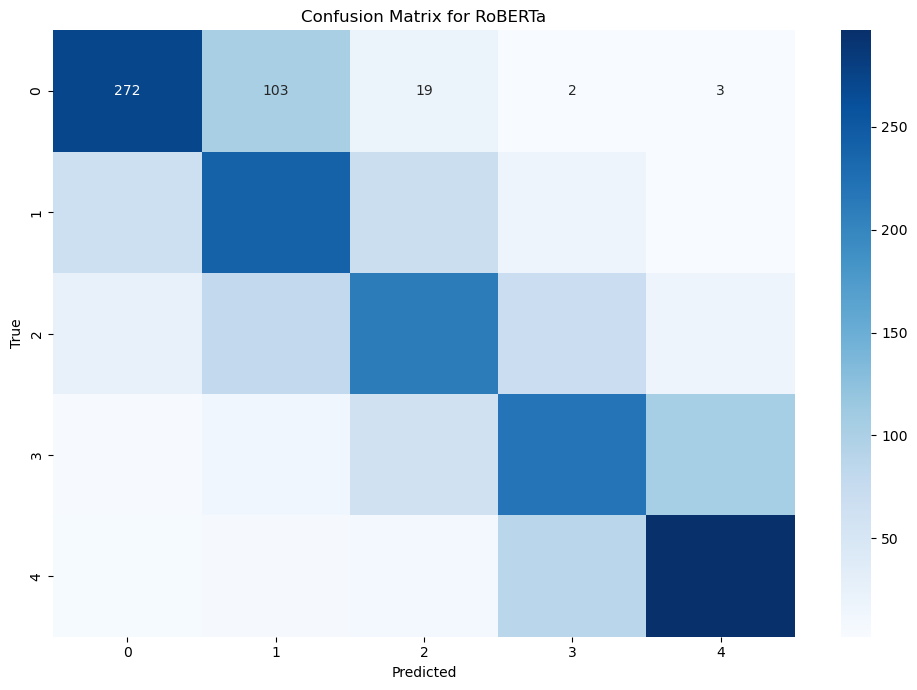

[I 2024-06-10 20:20:07,201] Trial 3 finished with value: 0.6194983574598518 and parameters: {'learning_rate': 4.7042371945698146e-05, 'batch_size': 26}. Best is trial 3 with value: 0.6194983574598518.
INFO:Sentiment-Analysis:Training model: RoBERTa
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:Sentiment-Analysis:Unique labels: {0, 1, 2, 3, 4}
INFO:Sentiment-Analysis:Unique labels: {0, 1, 2, 3, 4}
C:\Users\david\anaconda3\envs\SentimentAnalysis\lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss


In [ ]:
import os
import pandas as pd
import torch
import optuna
from transformers import (
    AutoTokenizer,
    RobertaForSequenceClassification,
    DistilBertForSequenceClassification,
    ElectraForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    EarlyStoppingCallback
)
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import gradio as gr
import logging
import numpy as np
import json
import yaml

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger('Sentiment-Analysis')

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    logger.info(f"Using device: {torch.cuda.get_device_name(0)}")

model_names = {
    'RoBERTa': ('roberta-base', RobertaForSequenceClassification),
    'DistilBERT': ('distilbert-base-uncased', DistilBertForSequenceClassification),
    'Electra': ('google/electra-base-discriminator', ElectraForSequenceClassification)
}

# Load abbreviations from the YAML file
with open('./data/abbreviations.yaml', 'r') as file:
    abbreviations = yaml.safe_load(file)

def replace_abbreviations(text):
    for abbr, full_form in abbreviations.items():
        text = text.replace(abbr, full_form)
    return text

class SentimentDataset(Dataset):
    """
    Custom Dataset class for sentiment analysis.
    """
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

def validate_labels(labels):
    unique_labels = set(labels)
    logger.info(f"Unique labels: {unique_labels}")
    assert all(label in [0, 1, 2, 3, 4] for label in unique_labels), "Labels are out of the expected range."

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {
        'eval_accuracy': accuracy,
        'eval_precision': precision,
        'eval_recall': recall,
        'eval_f1': f1
    }

def plot_confusion_matrix(labels, preds, model_name):
    conf_mat = confusion_matrix(labels, preds)
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()  # Adjust layout to fit all elements
    plt.show()

def train_model(model_name, train_df, learning_rate=5e-5, batch_size=16, num_epochs=3, use_early_stopping=False):
    logger.info(f"Training model: {model_name}")
    tokenizer = AutoTokenizer.from_pretrained(model_names[model_name][0])
    model_class = model_names[model_name][1]
    model = model_class.from_pretrained(model_names[model_name][0], num_labels=5)

    # Preprocess data and split into training and validation sets
    train_df['text'] = train_df['text'].apply(replace_abbreviations)  # Replace abbreviations
    train_texts, val_texts, train_labels, val_labels = train_test_split(
        train_df['text'].tolist(), train_df['label'].tolist(), test_size=0.2, random_state=42)

    validate_labels(train_labels)
    validate_labels(val_labels)

    train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
    val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)

    train_dataset = SentimentDataset(train_encodings, train_labels)
    val_dataset = SentimentDataset(val_encodings, val_labels)

    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=num_epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
        evaluation_strategy="epoch",
        learning_rate=learning_rate,
        load_best_model_at_end=use_early_stopping,
        metric_for_best_model="eval_f1",
        greater_is_better=True,
    )

    data_collator = DataCollatorWithPadding(tokenizer)

    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)] if use_early_stopping else []

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        callbacks=callbacks
    )

    trainer.train()
    eval_results = trainer.evaluate()
    predictions = trainer.predict(val_dataset)

    # Save the model and tokenizer
    model.save_pretrained(f"./models/{model_name}")
    tokenizer.save_pretrained(f"./models/{model_name}")

    # Save evaluation results
    eval_results['predictions'] = predictions.predictions.tolist()  # Convert to list for serialization
    eval_results['labels'] = val_labels  # Add true labels for confusion matrix generation
    with open(f"./models/{model_name}_eval_results.json", "w") as f:
        json.dump(eval_results, f)

    # Remove the 'predictions' and 'labels' keys for logging
    eval_results_to_log = {k: v for k, v in eval_results.items() if k not in ['predictions', 'labels']}
    
    logger.info(f"Evaluation results for {model_name}: {eval_results_to_log}")
    
    # Plot confusion matrix
    predictions = np.argmax(np.array(eval_results['predictions']), axis=1)
    logger.info(f"Confusion matrix data - Labels: {eval_results['labels'][:10]} Predictions: {predictions[:10]}")
    plot_confusion_matrix(eval_results['labels'], predictions, model_name)

    return model, tokenizer, eval_results

def load_model(model_name):
    tokenizer = AutoTokenizer.from_pretrained(f"./models/{model_name}")
    model_class = model_names[model_name][1]
    model = model_class.from_pretrained(f"./models/{model_name}")
    # Load evaluation results
    with open(f"./models/{model_name}_eval_results.json", "r") as f:
        eval_results = json.load(f)
    
    # Remove the 'predictions' and 'labels' keys for logging
    eval_results_to_log = {k: v for k, v in eval_results.items() if k not in ['predictions', 'labels']}
    
    logger.info(f"Loaded evaluation results for {model_name}: {eval_results_to_log}")
    
    # Plot confusion matrix
    predictions = np.argmax(np.array(eval_results['predictions']), axis=1)
    logger.info(f"Confusion matrix data - Labels: {eval_results['labels'][:10]} Predictions: {predictions[:10]}")
    plot_confusion_matrix(eval_results['labels'], predictions, model_name)
    
    return model, tokenizer, eval_results

def objective(trial):
    model_name = best_model_name  # Use the best model selected from initial training
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True)
    batch_size = trial.suggest_int("batch_size", 16, 32)
    train_df = pd.read_csv('./data/Sentiment_Training.csv', sep=';')
    _, _, eval_results = train_model(model_name, train_df, learning_rate, batch_size)
    return eval_results['eval_f1']

# Load the data
train_df = pd.read_csv('./data/Sentiment_Training.csv', sep=';')
test_df = pd.read_csv('./data/Sentiment_Test.csv', sep=';')

# Replace abbreviations in test data
test_df['text'] = test_df['text'].apply(replace_abbreviations)

# Initial training and evaluation
models = {}
results = {}
for model_name in model_names.keys():
    model_dir = f"./models/{model_name}"
    if os.path.exists(model_dir):
        logger.info(f"Loading existing model: {model_name}")
        model, tokenizer, eval_results = load_model(model_name)
        if 'eval_f1' not in eval_results:
            logger.info(f"Re-evaluating model: {model_name} to include 'eval_f1' metric.")
            torch.cuda.empty_cache()
            model, tokenizer, eval_results = train_model(model_name, train_df)
    else:
        # Clear CUDA cache before training each model
        torch.cuda.empty_cache()
        model, tokenizer, eval_results = train_model(model_name, train_df)
    models[model_name] = (model, tokenizer)
    results[model_name] = eval_results

if not results:
    logger.info("No models were trained. Exiting.")
    exit()

# Verify that eval_f1 score is in results
for model_name, eval_results in results.items():
    if 'eval_f1' not in eval_results:
        raise KeyError(f"Model {model_name} evaluation results do not contain 'eval_f1' metric.")

# Select the best model based on eval_f1 score
best_model_name = max(results, key=lambda k: results[k]['eval_f1'])
logger.info(f"Best model: {best_model_name} with F1 score: {results[best_model_name]['eval_f1']}")

# Clear CUDA cache before fine-tuning
torch.cuda.empty_cache()

# Check if the fine-tuned model exists
fine_tuned_model_dir = f"./models/{best_model_name}_fine_tuned"
if os.path.exists(fine_tuned_model_dir):
    logger.info(f"Loading existing fine-tuned model: {best_model_name}")
    best_model, best_tokenizer, best_eval_results = load_model(f"{best_model_name}_fine_tuned")
else:
    # Fine-tune the best model using Optuna
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=20)

    best_trial = study.best_trial
    logger.info(f"Best trial: {best_trial.params}")

    # Train the best model with the best hyperparameters
    best_learning_rate = best_trial.params['learning_rate']
    best_batch_size = best_trial.params['batch_size']
    best_model, best_tokenizer, best_eval_results = train_model(best_model_name, train_df, best_learning_rate, best_batch_size, use_early_stopping=True)

    # Save the fine-tuned model and evaluation results
    best_model.save_pretrained(fine_tuned_model_dir)
    best_tokenizer.save_pretrained(fine_tuned_model_dir)
    with open(f"./models/{best_model_name}_fine_tuned_eval_results.json", "w") as f:
        json.dump(best_eval_results, f)

def predict(model, tokenizer, text):
    text = replace_abbreviations(text)  # Replace abbreviations in the input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    model.to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1).item()
    return predictions

# Gradio interface
def predict_sample(sample_index):
    sample = test_df.iloc[sample_index]
    text = sample['text']
    ground_truth = sample['label']

    predictions = {}
    for model_name, (model, tokenizer) in models.items():
        predictions[model_name] = predict(model, tokenizer, text)
    
    predictions['Fine-Tuned'] = predict(best_model, best_tokenizer, text)
    
    return {
        "text": text,
        "ground_truth": ground_truth,
        "predictions": predictions
    }

sample_dropdown = gr.inputs.Dropdown(choices=[i for i in range(len(test_df))], label="Select a Sample")

iface = gr.Interface(
    fn=predict_sample,
    inputs=sample_dropdown,
    outputs="json",
    description="Sentiment Analysis Prediction"
)

iface.launch()
